This notebook shows how to use the general interface in HiGP for regression problems with a PyTorch optimizer.

We will apply GP to a one-dimensional dataset $X$ randomly sampled from $[0,1]$. The corresponding label is generated using a Gaussian Random Field. The data is stored in the file "Example00-EasyGPR.npz".

In this example, we use the Matern 3/2 kernel function in the form
$$
\mathcal{K}(x,y)=f^2 (1 + \sqrt{3} \frac{\|x - y\|_2}{l}) \exp\left(\frac{-\sqrt{3}\|x - y\|_2}{l}\right).
$$

As we hope to make the actual parameters in $(0,\infty)$, we train our parameters in $\mathbb{R}$, and apply the softplus transformation to get the actual parameters.

In [1]:
import higp
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

Load the dataset.

In [2]:
np_dtype = np.float32
data = np.load("Example00-EasyGPR.npz")
train_x = data["train_x"].astype(np_dtype)
train_y = data["train_y"].astype(np_dtype)
test_x = data["test_x"].astype(np_dtype)
test_y = data["test_y"].astype(np_dtype)

n_train = train_x.shape[1]
n_test = test_x.shape[1]

Create a GP regression model and a PyTorch Adam optimizer.

We use Matern 3/2 kernel by setting `kernel_type = 2`.

In [3]:
torch_dtype = torch.float32 if np_dtype == np.float32 else torch.float64
gprproblem = higp.gprproblem.setup(data = train_x, label = train_y, kernel_type = 2)
model = higp.GPRModel(gprproblem, dtype = torch_dtype)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

Run 50 steps of Adam.

In [4]:
loss_history, param_histpry = higp.gpr_torch_minimize(model, optimizer, maxits = 50, print_info = True)

Iteration (max 50), Elapsed time (sec), Loss, Hyperparameters (l, s, f, before nnt)
1, 0.01, 0.95127, -0.100, -0.100, 0.100
2, 0.01, 0.90625, -0.200, -0.200, 0.200
3, 0.01, 0.85813, -0.300, -0.300, 0.300
4, 0.01, 0.80707, -0.401, -0.401, 0.400
5, 0.02, 0.75374, -0.502, -0.502, 0.501
6, 0.02, 0.69916, -0.603, -0.603, 0.600
7, 0.02, 0.64435, -0.704, -0.705, 0.698
8, 0.02, 0.59021, -0.804, -0.807, 0.795
9, 0.03, 0.53741, -0.902, -0.910, 0.889
10, 0.03, 0.48641, -0.998, -1.013, 0.979
11, 0.03, 0.43743, -1.090, -1.116, 1.064
12, 0.03, 0.39048, -1.177, -1.220, 1.144
13, 0.04, 0.34537, -1.259, -1.324, 1.219
14, 0.04, 0.30178, -1.334, -1.429, 1.286
15, 0.04, 0.25939, -1.401, -1.533, 1.347
16, 0.04, 0.21787, -1.460, -1.638, 1.400
17, 0.05, 0.17692, -1.511, -1.743, 1.446
18, 0.05, 0.13630, -1.552, -1.848, 1.486
19, 0.05, 0.09582, -1.584, -1.953, 1.518
20, 0.05, 0.05535, -1.607, -2.058, 1.543
21, 0.06, 0.01477, -1.621, -2.163, 1.562
22, 0.06, -0.02595, -1.627, -2.268, 1.574
23, 0.06, -0.06683, -1

Run predictions with the initial parameters and the trained parameters.

In [5]:
Pred0 = higp.gpr_prediction(data_train = train_x,
                            label_train = train_y,
                            data_prediction = test_x,
                            kernel_type = 2,
                            pyparams = np.hstack((0.0, 0.0, 0.0)))   # Initial parameters

Pred = higp.gpr_prediction(data_train = train_x,
                           label_train = train_y,
                           data_prediction = test_x,
                           kernel_type = 2,
                           exact_gp = 0,
                           pyparams = model.get_params())         # Trained parameters

Now let us check the root mean squared errir (RMSE) of the predition.

In [6]:
rmse0 = np.linalg.norm(Pred0[0] - test_y) / np.sqrt(float(n_test))
rmse = np.linalg.norm(Pred[0] - test_y) / np.sqrt(float(n_test))
print("RMSE (before training): %g, RMSE (after training): %g\n" % (rmse0, rmse))

RMSE (before training): 0.460758, RMSE (after training): 0.0915793



Finally, plot the results.

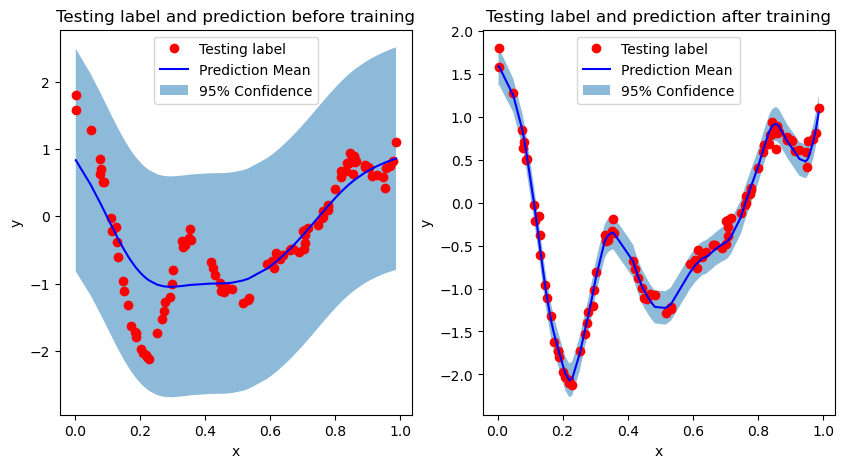

In [7]:
idx = np.argsort(test_x[0,:])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(test_x[0,idx], test_y[idx], 'ro')
axs[0].plot(test_x[0,idx], Pred0[0][idx], 'b-')
axs[0].fill_between(test_x[0,idx], Pred0[0][idx] - 1.96 * Pred0[1][idx], Pred0[0][idx] + 1.96 * Pred0[1][idx], alpha=0.5)
axs[0].set_title('Testing label and prediction before training')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].legend(['Testing label', 'Prediction Mean', '95% Confidence'], loc='upper center')
axs[1].plot(test_x[0,idx], test_y[idx], 'ro')
axs[1].plot(test_x[0,idx], Pred[0][idx], 'b-')
axs[1].fill_between(test_x[0,idx], Pred[0][idx] - 1.96 * Pred[1][idx], Pred[0][idx] + 1.96 * Pred[1][idx], alpha=0.5)
axs[1].set_title('Testing label and prediction after training')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].legend(['Testing label', 'Prediction Mean', '95% Confidence'], loc='upper center')
plt.show()
plt.close(fig)